# ARDL model

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.ardl import ARDL
from statsmodels.tsa.stattools import pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error
from pykalman import KalmanFilter

## Loading data

In [92]:
# Loading the data
file_path = "../../Data/train/train1990s.csv"
df = pd.read_csv(file_path)

# Convert to datetime and set as index
df["observation_date"] = pd.to_datetime(df["observation_date"])
df.set_index("observation_date", inplace=True)

# Ensure target variable exists
if "fred_PCEPI" not in df.columns:
    raise ValueError("Column 'fred_PCEPI' not found in dataset")

# Keep only the target, drop rows where it's missing
df = df[["fred_PCEPI"]].dropna()

# (A) LOG-TRANSFORM (assuming PCEPI > 0)
df["log_pcepi"] = np.log(df["fred_PCEPI"])

/var/folders/zl/9pkc8yr56sng48y79856qgz80000gp/T/ipykernel_5892/3843513128.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["observation_date"] = pd.to_datetime(df["observation_date"])


In [93]:
# Train/Tets split
train_size = int(0.90 * len(df))
train_df = df.iloc[:train_size].copy()
test_df  = df.iloc[train_size:].copy()

print(f"Train set size: {len(train_df)}")
print(f"Test  set size: {len(test_df)}")

Train set size: 334
Test  set size: 38


## Lags

In [94]:
# Select lags on the log-level series (no differnecing)
def best_lag_selection(train_series, max_lags=12):
    """
    Picks a 'best_lag' for ARDL in levels by:
      1) Checking partial autocorrelation (PACF)
      2) Checking a simple AR(lag) model's AIC
    Returns an integer 'best_lag'.
    """
    pacf_vals = pacf(train_series, nlags=max_lags)
    best_pacf_lag = np.argmax(np.abs(pacf_vals[1:])) + 1

    best_aic_lag, best_aic = 1, float("inf")
    for lag in range(1, max_lags + 1):
        y = train_series[lag:]
        X = train_series.shift(lag)[lag:]
        X = sm.add_constant(X, prepend=True)
        try:
            model = sm.OLS(y, X).fit()
            if model.aic < best_aic:
                best_aic_lag = lag
                best_aic = model.aic
        except:
            continue

    selected_lag = min(best_pacf_lag, best_aic_lag)
    print(f" - best_lag by PACF: {best_pacf_lag}, best_lag by AIC: {best_aic_lag}")
    return selected_lag

best_lag = best_lag_selection(train_df["log_pcepi"], max_lags=12)
print(f"Selected best lag (TRAIN only) for ARDL in levels: {best_lag}")

 - best_lag by PACF: 1, best_lag by AIC: 1
Selected best lag (TRAIN only) for ARDL in levels: 1


## Model Summary

In [95]:
# ARDL model with a linear trend since no exogenous variables
final_model = ARDL(endog=train_df["log_pcepi"], lags=best_lag, trend='ct').fit()
print("\n=== ARDL (levels) Model Summary ===")
print(final_model.summary())


=== ARDL (levels) Model Summary ===
                              ARDL Model Results                              
Dep. Variable:              log_pcepi   No. Observations:                  334
Model:                       ARDL(1,)   Log Likelihood                1621.199
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Tue, 25 Mar 2025   AIC                          -3234.398
Time:                        01:42:59   BIC                          -3219.165
Sample:                    02-01-1990   HQIC                         -3228.324
                         - 10-01-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0515      0.031      1.653      0.099      -0.010       0.113
trend         1.593e-05   1.23e-05      1.298      0.195   -8.22e-06    4.01e-05
log_pce

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Kalman Filter

In [96]:
# Forecast in log-levels
start_idx = test_df.index[0]
end_idx   = test_df.index[-1]

pred_log_test = final_model.predict(start=start_idx, end=end_idx)
pred_log_test = pd.Series(pred_log_test, index=test_df.index)

# Exponentiate to get back to original scale (raw predictions)
predictions_raw = np.exp(pred_log_test)  # "raw" ARDL forecast in original PCEPI scale

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [97]:
# Kalman Filter on the test forecast 
kf = KalmanFilter(initial_state_mean=predictions_raw.iloc[0], n_dim_obs=1)
kf = kf.em(predictions_raw, n_iter=5)

predictions_smoothed_arr, _ = kf.filter(predictions_raw)
predictions_smoothed = pd.Series(predictions_smoothed_arr.flatten(), 
                                 index=predictions_raw.index)

## Evaluation


=== Evaluation on Test Set ===
RAW Forecast  =>  MAE = 0.3010,  RMSE = 0.4066
Smoothed      =>  MAE = 0.3156,  RMSE = 0.4019


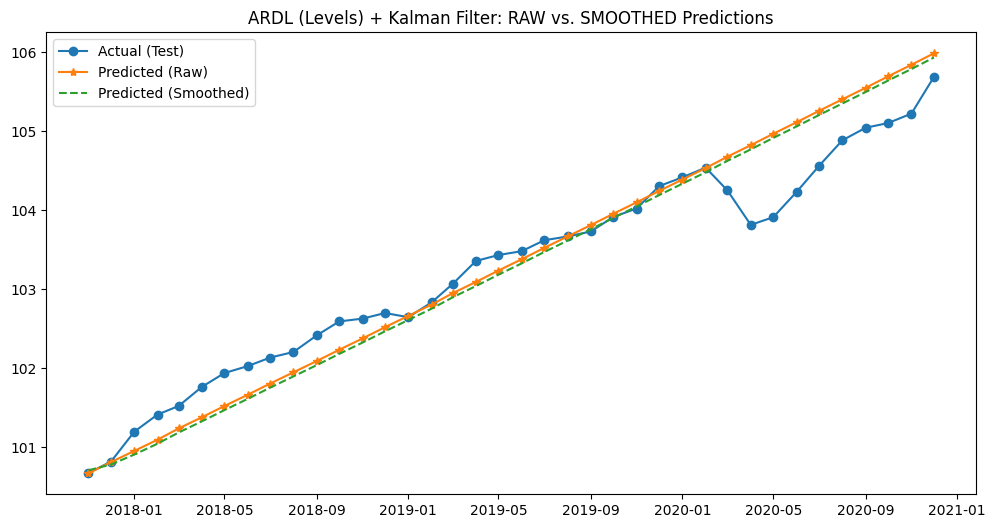

In [98]:
# Evaluation
y_true = test_df["fred_PCEPI"]

# Align both raw and smoothed with the test index
y_pred_raw     = predictions_raw.reindex(y_true.index)
y_pred_smoothed = predictions_smoothed.reindex(y_true.index)

# Evaluate RAW
mae_raw = mean_absolute_error(y_true, y_pred_raw)
rmse_raw = np.sqrt(mean_squared_error(y_true, y_pred_raw))

# Evaluate SMOOTHED
mae_smooth = mean_absolute_error(y_true, y_pred_smoothed)
rmse_smooth = np.sqrt(mean_squared_error(y_true, y_pred_smoothed))

print(f"\n=== Evaluation on Test Set ===")
print(f"RAW Forecast  =>  MAE = {mae_raw:.4f},  RMSE = {rmse_raw:.4f}")
print(f"Smoothed      =>  MAE = {mae_smooth:.4f},  RMSE = {rmse_smooth:.4f}")

# Plotting
plt.figure(figsize=(12,6))
plt.plot(y_true.index, y_true, label="Actual (Test)", marker="o")
plt.plot(y_pred_raw.index, y_pred_raw, label="Predicted (Raw)", marker="*")
plt.plot(y_pred_smoothed.index, y_pred_smoothed, 
         label="Predicted (Smoothed)", linestyle="--")
plt.legend()
plt.title("ARDL (Levels) + Kalman Filter: RAW vs. SMOOTHED Predictions")
plt.show()


# With Exogenous Variables to catch trends

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.ardl import ARDL
from statsmodels.tsa.stattools import pacf
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pykalman import KalmanFilter

## Load Data and Preprocessing

In [100]:
# Load Data
df = pd.read_csv("../../Data/Train/train1990s.csv")
df["observation_date"] = pd.to_datetime(df["observation_date"], format="%m/%Y")
df.set_index("observation_date", inplace=True)

In [101]:
# Preprocessing
df.dropna(inplace=True)
df["log_pcepi"] = np.log(df["fred_PCEPI"])
df["sin_month"] = np.sin(2 * np.pi * df.index.month / 12)
df["cos_month"] = np.cos(2 * np.pi * df.index.month / 12)
df["momentum"] = df["log_pcepi"].diff()
df.dropna(inplace=True)  # Remove rows with NaNs from momentum

## Train/Val split

In [102]:
# Train/Val Split 
split = int(0.8 * len(df))
train_df = df.iloc[:split].copy()
val_df = df.iloc[split:].copy()

# Drop near-constant columns 
def drop_near_constant_cols(dataframe, threshold=1e-6):
    return dataframe.loc[:, dataframe.std() > threshold]

exog_cols = [col for col in df.columns if col not in ["fred_PCEPI", "log_pcepi"]]
train_exog = drop_near_constant_cols(train_df[exog_cols])
val_exog = val_df[train_exog.columns]  # keep same cols in val

## PCA

In [103]:
# PCA without Standardization
NUM_COMPONENTS = 10
pca = PCA(n_components=NUM_COMPONENTS)
train_pca = pca.fit_transform(train_exog)
val_pca = pca.transform(val_exog)

pca_cols = [f"PC{i+1}" for i in range(NUM_COMPONENTS)]
train_exog_pca = pd.DataFrame(train_pca, index=train_exog.index, columns=pca_cols)
val_exog_pca = pd.DataFrame(val_pca, index=val_exog.index, columns=pca_cols)

In [104]:
# Add 1 Lag to PCA 
def add_lags(df_pca, lags=1):
    out = df_pca.copy()
    for col in df_pca.columns:
        for l in range(1, lags+1):
            out[f"{col}_L{l}"] = df_pca[col].shift(l)
    return out

train_lagged = add_lags(train_exog_pca, lags=1).dropna()
val_lagged = add_lags(val_exog_pca, lags=1).dropna()

## Model Define

### Why Was Lag 1 Selected in the ARDL Model?

- Used the Partial Autocorrelation Function (PACF) to determine the optimal number of autoregressive lags for the endogenous variable
- The function returned lag 1, suggesting that the first lag of log_pcepi carries the most significant predictive power.

In [105]:
# Align Targets 
train_target = train_df["log_pcepi"].loc[train_lagged.index]
val_target = val_df["fred_PCEPI"].loc[val_lagged.index]

# Reindex for ARDL 
train_idx = np.arange(len(train_lagged))
val_idx = np.arange(len(val_lagged))
train_lagged.index = train_idx
val_lagged.index = val_idx
train_target.index = train_idx
val_target.index = val_idx

# Auto-select Best Lag
def best_lag(series, max_lags=24):
    pacf_vals = pacf(series, nlags=max_lags)
    return np.argmax(np.abs(pacf_vals[1:])) + 1

best_lag_value = best_lag(train_target)

# Train ARDL Model 
model = ARDL(endog=train_target, exog=train_lagged, lags=best_lag_value, trend='ct').fit()
print(model.summary())

                                                       ARDL Model Results                                                      
Dep. Variable:                                                               log_pcepi   No. Observations:                  295
Model:             ARDL(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)   Log Likelihood                1485.872
Method:                                                                Conditional MLE   S.D. of innovations              0.002
Date:                                                                 Tue, 25 Mar 2025   AIC                          -2923.744
Time:                                                                         01:42:59   BIC                          -2835.338
Sample:                                                                              1   HQIC                         -2888.340
                                                                                   295                  

## Kalman Soothing

In [106]:
# Forecast 
start = len(train_lagged)
end = start + len(val_lagged) - 1
log_preds = model.predict(start=start, end=end, exog_oos=val_lagged)
log_preds.index = val_idx
preds = np.exp(log_preds)

In [107]:
# Kalman Smoothing 
kf = KalmanFilter(initial_state_mean=preds.iloc[0], n_dim_obs=1)
kf = kf.em(preds, n_iter=5)
smoothed_preds, _ = kf.filter(preds)
smoothed_preds = pd.Series(smoothed_preds.flatten(), index=val_idx)

## Evaluation


=== Evaluation ===
Raw      => MAE: 0.4628, RMSE: 0.7754
Smoothed => MAE: 0.4565, RMSE: 0.7761


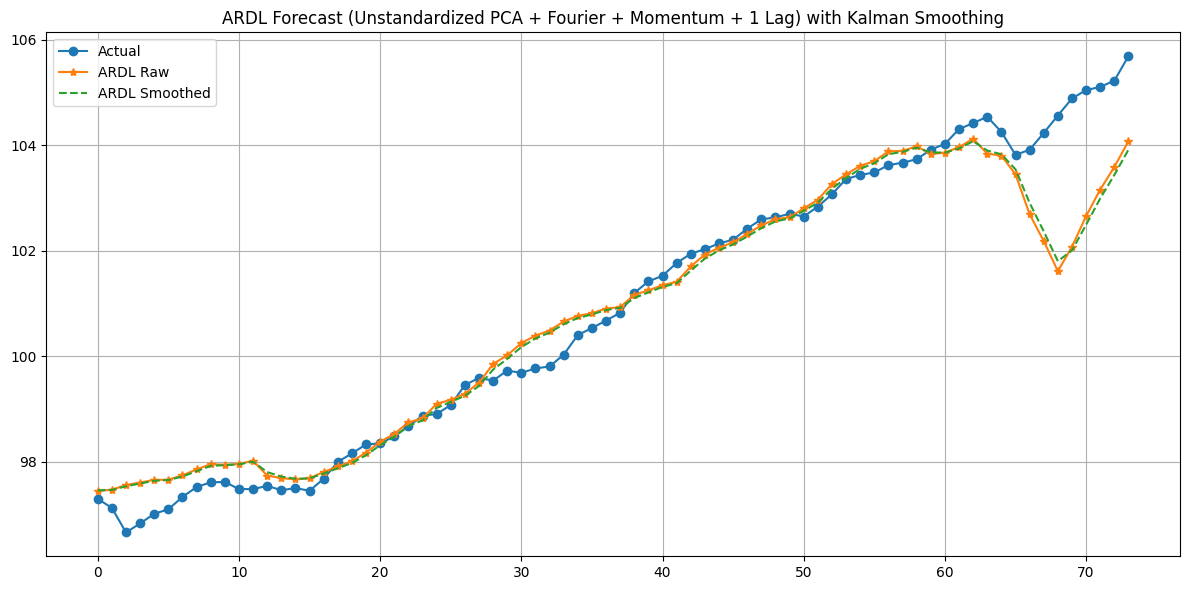

In [108]:
# Evaluation 
mae_raw = mean_absolute_error(val_target, preds)
rmse_raw = np.sqrt(mean_squared_error(val_target, preds))
mae_smooth = mean_absolute_error(val_target, smoothed_preds)
rmse_smooth = np.sqrt(mean_squared_error(val_target, smoothed_preds))

print(f"\n=== Evaluation ===")
print(f"Raw      => MAE: {mae_raw:.4f}, RMSE: {rmse_raw:.4f}")
print(f"Smoothed => MAE: {mae_smooth:.4f}, RMSE: {rmse_smooth:.4f}")

# === Plot ===
plt.figure(figsize=(12, 6))
plt.plot(val_idx, val_target, label="Actual", marker="o")
plt.plot(val_idx, preds, label="ARDL Raw", marker="*")
plt.plot(val_idx, smoothed_preds, label="ARDL Smoothed", linestyle="--")
plt.title("ARDL Forecast (Unstandardized PCA + Fourier + Momentum + 1 Lag) with Kalman Smoothing")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Adjustments for 48-Month Forecast & Evaluation

In [123]:
# Load Actual Test Set 
test_df = pd.read_csv("../../Data/Test/test1990s.csv")
test_df["observation_date"] = pd.to_datetime(test_df["observation_date"], format="%m/%Y")
test_df.set_index("observation_date", inplace=True)

# Preprocess Test Set 
test_df["log_pcepi"] = np.log(test_df["fred_PCEPI"])
test_df["sin_month"] = np.sin(2 * np.pi * test_df.index.month / 12)
test_df["cos_month"] = np.cos(2 * np.pi * test_df.index.month / 12)
test_df["momentum"] = test_df["log_pcepi"].diff()
test_df.dropna(inplace=True)

# Use Same Features As Train 
test_exog = test_df[train_exog.columns]

# Apply PCA + Lag 
test_pca = pca.transform(test_exog)
test_exog_pca = pd.DataFrame(test_pca, index=test_exog.index, columns=pca_cols)
test_lagged = add_lags(test_exog_pca, lags=1).dropna()

# Forecast 
start = len(train_lagged)
end = start + len(test_lagged) - 1
log_test_preds = model.predict(start=start, end=end, exog_oos=test_lagged)
test_preds = np.exp(log_test_preds)

# Ensure 48-Length Prediction
final_preds = np.zeros(48)
if len(test_preds) >= 48:
    final_preds[:] = test_preds.values[-48:]
else:
    # Right-align predictions, fill earlier steps with the first forecast value
    pad_len = 48 - len(test_preds)
    final_preds[:pad_len] = test_preds.iloc[0]
    final_preds[pad_len:] = test_preds.values

# Save to .npy
np.save("../../Predictions/ARDL.npy", final_preds)
print(f"Final ARDL.npy saved")


Final ARDL.npy saved
